In [1]:
import raw_data
import ta

import math
import time

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("amzn")
prediction_period = 1  # predict 1 day into the future
saved_models_root = "saved_models/"

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5361.000000,5361.000000,5361.000000,5361.000000,5361.000000,5.361000e+03,5361.0,5361.000000
mean,239.727108,242.617142,236.626308,239.782513,232.272085,6.498490e+06,0.0,1.000746
std,347.171219,349.844764,343.938938,347.153621,350.542372,5.438907e+06,0.0,0.033449
min,5.910000,6.100000,5.510000,5.970000,1.395800,4.060000e+04,0.0,1.000000
25%,40.350000,41.250000,39.700000,40.380000,36.070000,3.475069e+06,0.0,1.000000
50%,86.380000,88.500000,84.370000,86.360000,74.870000,5.431700e+06,0.0,1.000000
75%,271.430000,275.460000,269.230000,272.870000,269.900000,7.950300e+06,0.0,1.000000
max,2007.000000,2025.570000,2004.740000,2012.710000,2012.710000,1.043292e+08,0.0,3.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,2007.00,2022.38,2004.74,2012.71,2012.71,4147979,0.0,1.0
1,2018-08-30,1997.42,2025.57,1986.90,2002.38,2002.38,7277257,0.0,1.0
2,2018-08-29,1953.45,1998.69,1948.94,1998.10,1998.10,6531761,0.0,1.0
3,2018-08-28,1937.73,1941.78,1928.82,1932.82,1932.82,3100727,0.0,1.0
4,2018-08-27,1915.00,1927.70,1909.28,1927.68,1927.68,3569037,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_percent_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_percent_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes * 100.0
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_percent_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_percent_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
count,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,...,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5.360000e+03,5360.000000
mean,1.450780e-14,1.739239e-14,3.902682e-15,2.121023e-15,-4.242046e-17,1.908921e-16,3.976918e-18,2.651279e-17,-6.363069e-17,-1.524485e-17,...,-4.454148e-16,-8.484092e-16,6.999376e-16,1.845290e-15,6.575172e-16,5.938865e-16,-4.639738e-17,-4.639738e-18,-2.969432e-15,0.200927
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.820856
min,-6.741115e-01,-6.766870e-01,-6.726078e-01,-6.592055e-01,-1.187341e+00,-1.056156e+01,-1.233426e+01,-5.277812e+00,-5.826587e+00,-1.593361e+01,...,-5.758587e+00,-2.966940e+00,-9.081656e+00,-8.440389e+00,-9.081656e+00,-6.280881e+00,-6.833557e+00,-7.833632e+00,-6.592055e-01,-24.766064
25%,-5.746783e-01,-5.759941e-01,-5.730004e-01,-5.600671e-01,-5.559419e-01,1.532257e-01,-6.314131e-01,-4.942433e-01,2.816623e-01,-6.313975e-02,...,-7.355089e-01,-1.295330e-03,-4.521722e-02,-2.167415e-02,-4.521722e-02,-1.492573e-01,-3.955843e-01,-3.777562e-01,-5.600671e-01,-1.368653
50%,-4.418986e-01,-4.406338e-01,-4.429518e-01,-4.491745e-01,-1.960941e-01,2.433182e-01,-2.426193e-02,3.769917e-04,2.968710e-01,-2.870782e-02,...,-2.560875e-02,2.879081e-01,1.860271e-01,1.949672e-01,1.860271e-01,1.558523e-01,6.442174e-03,2.513239e-02,-4.491745e-01,0.035807
75%,9.217957e-02,9.500547e-02,9.593841e-02,1.084338e-01,2.669767e-01,3.098652e-01,6.438290e-01,4.792793e-01,3.118234e-01,1.112032e-02,...,6.853009e-01,5.208635e-01,5.006880e-01,4.947725e-01,5.006880e-01,3.381511e-01,3.864681e-01,4.004362e-01,1.084338e-01,1.563407
max,5.075663e+00,5.109237e+00,5.101988e+00,5.062302e+00,1.798576e+01,2.399938e+00,9.385396e+00,5.378748e+00,3.750009e-01,2.683463e+01,...,2.860975e+00,1.685661e+00,7.948820e-01,7.775113e-01,7.948820e-01,8.354926e+00,8.811165e+00,7.593819e+00,5.062302e+00,34.471366


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_percent_change
1,5.075663,5.109237,5.101988,5.062302,0.143093,0.245829,0.000797,0.002379,0.293342,-0.028931,...,0.499269,0.307441,0.31254,0.315887,0.31254,0.226888,0.015707,0.034346,5.062302,0.515886
2,4.948715,5.032224,4.991357,5.050064,0.006036,0.337690,-0.771466,0.002379,0.293342,-0.028931,...,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.041403,-0.022496,5.050064,0.214203
3,4.903329,4.869173,4.932719,4.863406,-0.624748,0.342618,-0.365808,0.002379,0.293342,4.522758,...,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.857220,-0.848046,4.863406,3.377448
4,4.837705,4.828833,4.875771,4.848709,-0.538650,0.290112,-0.421177,0.002379,0.293342,3.239841,...,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.055346,-0.036393,4.848709,0.266642
5,4.824741,4.795340,4.856128,4.784974,-0.679876,0.282112,-0.330354,0.002379,0.293342,0.099938,...,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.293244,-0.274615,4.784974,1.169839


In [6]:
num_rows = len(df)
# Use 85% for training, 10% for validation, and most recent 5% for testing
num_training = int(num_rows * 0.85)
num_validation = int(num_rows * 0.1)
num_testing = num_rows - num_training - num_validation

testing_examples = preprocess_features(df.head(num_testing))
testing_targets = preprocess_targets(df.head(num_testing))

remaining_df = df[num_testing:].sample(frac=1)  # Shuffle remaining_df before splitting into training and validation sets

training_examples = preprocess_features(remaining_df.head(num_training))
training_targets = preprocess_targets(remaining_df.head(num_training))

validation_examples = preprocess_features(remaining_df.tail(num_validation))
validation_targets = preprocess_targets(remaining_df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Testing examples summary:")
display.display(testing_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Testing targets summary:")
display.display(testing_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,...,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000,4556.000000
mean,-0.176148,-0.176261,-0.176117,-0.175895,0.014569,-0.014301,0.010447,0.013196,-0.021028,0.001524,...,0.033944,0.076995,-0.021955,-0.013934,-0.014090,-0.013934,0.105035,-0.000517,-0.001494,-0.175895
std,0.628977,0.628267,0.629501,0.632576,0.993162,1.025863,1.004727,1.009970,1.033475,0.877577,...,0.996595,0.918070,1.027277,1.032072,1.033018,1.032072,0.750363,1.024487,1.026470,0.632576
min,-0.674112,-0.676687,-0.672608,-0.659206,-1.187341,-10.561558,-12.334259,-5.075857,-5.826587,-11.798307,...,-3.029812,-2.448644,-2.966940,-9.081656,-8.440389,-9.081656,-4.002544,-6.833557,-7.833632,-0.659206
25%,-0.577659,-0.579559,-0.575820,-0.562583,-0.541553,0.149355,-0.640526,-0.481240,0.280657,-0.059519,...,-0.638734,-0.652171,-0.011600,-0.046058,-0.020055,-0.046058,-0.090831,-0.409332,-0.391642,-0.562583
50%,-0.456089,-0.454988,-0.455673,-0.464272,-0.173014,0.242859,-0.011777,0.011168,0.296567,-0.028693,...,0.074479,0.022570,0.282277,0.193295,0.200816,0.193295,0.167415,0.010279,0.028948,-0.464272
75%,-0.015540,-0.016417,-0.016820,-0.001622,0.285449,0.310668,0.663382,0.500714,0.311459,0.008384,...,0.736256,0.727700,0.519703,0.505652,0.502019,0.505652,0.344478,0.402320,0.415977,-0.001622
max,2.396769,2.409596,2.351653,2.347123,17.985755,2.399938,7.156036,5.378748,0.375001,19.824083,...,3.006769,2.860975,1.685661,0.794882,0.777511,0.794882,8.354926,7.473744,6.574098,2.347123


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,...,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,-0.166513,-0.166339,-0.165785,-0.163400,0.075664,-0.008108,-0.037301,0.060728,0.026410,-0.013481,...,0.050805,0.105465,0.026828,0.030763,0.031516,0.030763,0.082313,0.030249,0.030836,-0.163400
std,0.645676,0.645691,0.647501,0.649431,1.203234,1.008730,1.120455,1.067978,0.933913,0.757790,...,0.991919,0.943127,0.964263,0.948779,0.941770,0.948779,0.796907,0.992692,0.974990,0.649431
min,-0.673361,-0.676486,-0.671325,-0.658877,-1.186054,-7.317777,-9.101321,-5.277812,-5.092429,-8.134993,...,-2.818962,-2.412856,-2.790960,-6.245019,-6.298316,-6.245019,-4.027896,-5.233136,-5.775733,-0.658877
25%,-0.577147,-0.578136,-0.575536,-0.556343,-0.516630,0.142200,-0.679415,-0.467354,0.280151,-0.065137,...,-0.683676,-0.663721,0.014221,-0.043917,-0.028625,-0.043917,-0.123909,-0.393494,-0.375646,-0.556343
50%,-0.464346,-0.461148,-0.461750,-0.466345,-0.141889,0.234870,0.017326,0.026473,0.296416,-0.028912,...,0.105888,0.042633,0.298453,0.190764,0.199557,0.190764,0.154988,0.020769,0.039378,-0.466345
75%,-0.040550,-0.033428,-0.048121,-0.037229,0.357006,0.303974,0.648842,0.632933,0.313020,0.005892,...,0.765402,0.765953,0.535101,0.525289,0.518572,0.525289,0.353753,0.422977,0.436214,-0.037229
max,2.201079,2.195403,2.220213,2.214764,13.397902,1.481495,9.385396,4.301852,0.362556,12.088138,...,2.345414,2.849300,1.383366,0.793227,0.748384,0.793227,6.616271,8.811165,7.593819,2.214764


Testing examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,...,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,3.327541,3.329118,3.325563,3.317014,-0.399005,0.259340,-0.102994,-0.345791,0.304663,0.001052,...,-0.678656,-1.519853,0.319584,0.175358,0.176506,0.175358,-1.950220,-0.051712,-0.036278,3.317014
std,0.887456,0.889752,0.886278,0.879871,0.409701,0.085832,0.564567,0.503518,0.014376,2.404490,...,0.817663,1.211508,0.304274,0.244095,0.228549,0.244095,2.274576,0.431759,0.433690,0.879871
min,2.022740,2.023728,2.026841,2.020586,-0.909108,-0.034794,-1.933541,-2.184282,0.280049,-15.933614,...,-2.971665,-5.758587,-0.876652,-0.167235,-0.134286,-0.167235,-6.280881,-3.103314,-3.263154,2.020586
25%,2.559936,2.551968,2.581783,2.563633,-0.663125,0.216556,-0.467969,-0.644309,0.293342,-0.199811,...,-1.174855,-1.742068,0.187952,-0.035595,-0.020082,-0.035595,-3.556379,-0.280545,-0.261845,2.563633
50%,3.453940,3.466807,3.400158,3.428829,-0.517291,0.260942,-0.310618,-0.337052,0.300635,-0.028603,...,-0.686913,-1.391698,0.307441,0.128708,0.127470,0.128708,-1.984232,-0.068117,-0.049127,3.428829
75%,3.975878,3.955394,3.977890,3.942725,-0.262975,0.308464,0.379310,0.002379,0.314266,0.107408,...,-0.207951,-1.061275,0.521274,0.323275,0.317670,0.323275,0.054115,0.140478,0.158109,3.942725
max,5.075663,5.109237,5.101988,5.062302,1.813021,0.521834,1.544109,1.115000,0.345990,26.834628,...,1.760057,0.499269,1.124343,0.789228,0.742657,0.789228,4.563410,1.483104,1.454634,5.062302


Training targets summary:


count    4556.000000
mean        0.210384
std         3.928912
min       -21.821971
25%        -1.426336
50%         0.020321
75%         1.616510
max        34.471366
Name: future_percent_change, dtype: float64

Validation targets summary:


count    536.000000
mean       0.080245
std        3.664402
min      -24.766064
25%       -1.501402
50%       -0.018939
75%        1.555339
max       24.447509
Name: future_percent_change, dtype: float64

Testing targets summary:


count    268.000000
mean       0.281526
std        1.652743
min       -5.206102
25%       -0.464807
50%        0.331902
75%        1.121217
max       13.216375
Name: future_percent_change, dtype: float64

In [7]:
print("Data for the most recent 5 days:")
display.display(testing_examples.head(5))
display.display(testing_targets.head(5))

Data for the most recent 5 days:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
1,5.075663,5.109237,5.101988,5.062302,0.143093,0.245829,0.000797,0.002379,0.293342,-0.028931,...,0.014718,0.499269,0.307441,0.31254,0.315887,0.31254,0.226888,0.015707,0.034346,5.062302
2,4.948715,5.032224,4.991357,5.050064,0.006036,0.337690,-0.771466,0.002379,0.293342,-0.028931,...,0.014718,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.041403,-0.022496,5.050064
3,4.903329,4.869173,4.932719,4.863406,-0.624748,0.342618,-0.365808,0.002379,0.293342,4.522758,...,0.014718,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.857220,-0.848046,4.863406
4,4.837705,4.828833,4.875771,4.848709,-0.538650,0.290112,-0.421177,0.002379,0.293342,3.239841,...,0.014718,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.055346,-0.036393,4.848709
5,4.824741,4.795340,4.856128,4.784974,-0.679876,0.282112,-0.330354,0.002379,0.293342,0.099938,...,0.014718,-5.758587,0.307441,0.31254,0.315887,0.31254,0.226888,-0.293244,-0.274615,4.784974


1    0.515886
2    0.214203
3    3.377448
4    0.266642
5    1.169839
Name: future_percent_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    batch_norm,
    dropout,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    save_model=True):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    if save_model:
        dir_name = "{}-{}".format(optimizer.get_name(), time.strftime("%Y%m%d-%H%M%S"))
        model_dir = "{}{}".format(saved_models_root, dir_name)
    else:
        model_dir = None
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        batch_norm=batch_norm,
        dropout=dropout,
        hidden_units=hidden_units,
        optimizer=optimizer,
        model_dir=model_dir)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.381
  period 01 : 0.182
  period 02 : 0.131
  period 03 : 0.110
  period 04 : 0.092
  period 05 : 0.082
  period 06 : 0.078
  period 07 : 0.067
  period 08 : 0.061
  period 09 : 0.058
Model training finished.
Final RMSE (on training data):   0.058
Final RMSE (on validation data): 0.116


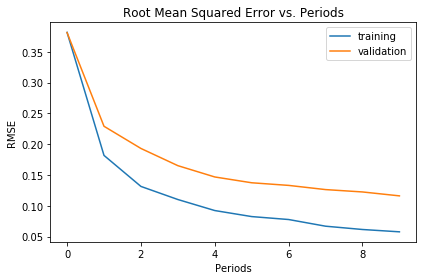

In [14]:
adam_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdamOptimizer(learning_rate=0.00028),
    steps=10000,
    batch_size=128,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
adagrad_regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.007),
    steps=10000,
    batch_size=30,
    batch_norm=False,
    dropout=None,
    hidden_units=[30, 30, 20, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
# Select regressor to use
regressor = adam_regressor

In [16]:
# Compute testing loss
predict_testing_input_fn = lambda: input_fn(testing_examples, testing_targets, num_epochs=1, shuffle=False)
testing_predictions = regressor.predict(input_fn=predict_testing_input_fn)
testing_predictions = np.array([item["predictions"][0] for item in testing_predictions])
testing_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(testing_predictions, testing_targets))
print("RMSE on testing data: %0.3f" % testing_root_mean_squared_error)

RMSE on testing data: 0.266


(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


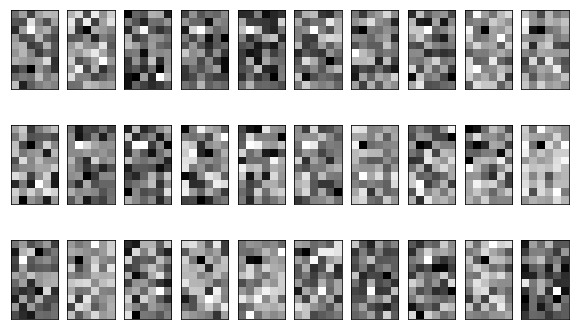

In [17]:
# Visualize weights from first layer
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Pad with 0s to make length 60
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [18]:
latest_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
latest_features = preprocess_features(latest_df).head(prediction_period)
latest_targets = preprocess_targets(latest_df).head(prediction_period)
predict_latest_input_fn = lambda: input_fn(latest_features, latest_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_latest_input_fn)
predictions = [item["predictions"][0] for item in predictions]
print("Current predictions (start of array is furthest into the future and end of array is 1 day into the future):")
display.display(predictions)

Current predictions (start of array is furthest into the future and end of array is 1 day into the future):


[0.13806307]